# EEG Data Processing using NATVIEW_EEGFMRI data

### Background

This project is a continuation of the first part of the NATVIEW_EEGFMRI data analysis, available at GitHub: https://github.com/Amanymarey2/EEG-Data-Analysis-with-MNE-Python/blob/main/EEG%20Analysis%20part%201.ipynb. The initial data exploration revealed prominent ocular artifacts, particularly in the frontal channels, manifesting as eye blink-related deflections (~5 µV at 0.1 s in EEG). In this second part, we focus on applying and evaluating different methods for artifact removal, including regression and Independent Component Analysis (ICA), to effectively mitigate these ocular artifacts and improve the quality of the EEG data for subsequent analysis.



In [1]:
#import packages
import os
import numpy as np
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.preprocessing import EOGRegression

import matplotlib
matplotlib.use('inline')

#### 1- Import the data sets

The data sets were saved as fif format to save channels and montage changes

##### Check data

In [2]:
check_eeg_data = mne.io.read_raw_fif('check_eeg_data_preprocessed.fif', preload = True)
check_eeg_data.info

Opening raw data file check_eeg_data_preprocessed.fif...
    Range : 0 ... 60499 =      0.000 ...   241.996 secs
Ready.
Reading 0 ... 60499  =      0.000 ...   241.996 secs...


C:\Users\amany\AppData\Local\Temp\ipykernel_17460\1258807143.py:1: RuntimeWarning: This filename (check_eeg_data_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  check_eeg_data = mne.io.read_raw_fif('check_eeg_data_preprocessed.fif', preload = True)


<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 61 EEG, 1 ECG, 2 EOG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 70.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

##### Rest Data

In [3]:
rest_eeg_data = mne.io.read_raw_fif('rest_eeg_data_preprocessed.fif', preload = True)
rest_eeg_data.info

Opening raw data file rest_eeg_data_preprocessed.fif...
    Range : 0 ... 155749 =      0.000 ...   622.996 secs
Ready.
Reading 0 ... 155749  =      0.000 ...   622.996 secs...


C:\Users\amany\AppData\Local\Temp\ipykernel_17460\1553556652.py:1: RuntimeWarning: This filename (rest_eeg_data_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  rest_eeg_data = mne.io.read_raw_fif('rest_eeg_data_preprocessed.fif', preload = True)


<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 61 EEG, 1 ECG, 2 EOG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 70.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

In [4]:
# Set a standard 10-10 montage with 128 channels
# MNE provides a 'standard_1005' montage that includes 10-10 system positions
montage = mne.channels.make_standard_montage('standard_1020')

#check data
check_eeg_data.set_montage(montage, on_missing='ignore')
check_eeg_data = check_eeg_data.copy().pick_types(eeg = True, eog = True, ecg = True)
check_eeg_data = check_eeg_data.set_montage('standard_1020')

#rest data
rest_eeg_data.set_montage(montage, on_missing='ignore')
rest_eeg_data = rest_eeg_data.copy().pick_types(eeg = True, eog = True, ecg = True)
rest_eeg_data = rest_eeg_data.set_montage('standard_1020')

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


#### 2- Create events from data annotations

We will extract events around "SYNC ON" stimulus as the ocular artifacts was found conciding with this event

##### Check Data

In [20]:
events, event_id = mne.events_from_annotations(check_eeg_data)
event_id

Used Annotations descriptions: [np.str_('New Segment'), np.str_('R'), np.str_('R128'), np.str_('S  1'), np.str_('S 10'), np.str_('S 11'), np.str_('S 12'), np.str_('S 25'), np.str_('S 26'), np.str_('S 27'), np.str_('S 99'), np.str_('Sync On'), np.str_('TEND'), np.str_('TPEAK'), np.str_('TSTART'), np.str_('Time 0'), np.str_('Userdefined Artifact')]


{np.str_('New Segment'): 1,
 np.str_('R'): 2,
 np.str_('R128'): 3,
 np.str_('S  1'): 4,
 np.str_('S 10'): 5,
 np.str_('S 11'): 6,
 np.str_('S 12'): 7,
 np.str_('S 25'): 8,
 np.str_('S 26'): 9,
 np.str_('S 27'): 10,
 np.str_('S 99'): 11,
 np.str_('Sync On'): 12,
 np.str_('TEND'): 13,
 np.str_('TPEAK'): 14,
 np.str_('TSTART'): 15,
 np.str_('Time 0'): 16,
 np.str_('Userdefined Artifact'): 17}

In [21]:
# Step 2: Identify stimulus events (e.g., "S  1", "S 10", etc.)
# List of stimulus event labels based on your annotations
stimulus_labels = ['Sync On']

# Extract events for each stimulus type
stimulus_events = {}
for label in stimulus_labels:
    if label in event_id:
        stim_id = event_id[label]  # Get the event ID for the stimulus
        stim_events = events[events[:, 2] == stim_id]  # Filter for this stimulus type
        stimulus_events[label] = stim_events
        # Convert sample numbers to time (in seconds)
        sfreq = check_eeg_data.info['sfreq']  # Sampling frequency (Hz)
        stim_times = stim_events[:, 0] / sfreq
        print(f"{label} event times (seconds):", stim_times)
    else:
        print(f"No events found for {label}")

# Step 3: Combine all stimulus events (optional)
# Concatenate all stimulus events into a single array
check_stimulus_events = np.concatenate([stimulus_events[label] for label in stimulus_events], axis=0)
# Sort by sample number to maintain chronological order
check_stimulus_events = check_stimulus_events[check_stimulus_events[:, 0].argsort()]
#Store stimulus events ID
check_event_id = {"Sync On" : 12}


Sync On event times (seconds): [  0.     1.08   3.08   5.08   7.08   9.08  11.08  13.08  15.08  17.08
  19.08  21.08  23.08  25.08  27.08  29.08  31.08  33.08  35.08  37.08
  39.08  41.08  43.08  45.08  47.08  49.08  51.08  53.08  55.08  57.08
  59.08  61.08  63.08  65.08  67.08  69.08  71.08  73.08  75.08  77.08
  79.08  81.08  83.08  85.08  87.08  89.08  91.08  93.08  95.08  97.08
  99.08 101.08 103.08 105.08 107.08 109.08 111.08 113.08 115.08 117.08
 119.08 121.08 123.08 125.08 127.08 129.08 131.08 133.08 135.08 137.08
 139.08 141.08 143.08 145.08 147.08 149.08 151.08 153.08 155.08 157.08
 159.08 161.08 163.08 165.08 167.08 169.08 171.08 173.08 175.08 177.08
 179.08 181.08 183.08 185.08 187.08 189.08 191.08 193.08 195.08 197.08
 199.08 201.08 203.08 205.08 207.08 209.08 211.08 213.08 215.08 217.08
 219.08 221.08 223.08 225.08 227.08 229.08 231.08 233.08 235.08 237.08
 239.08 241.08]


##### Rest Data

In [28]:
events, event_id = mne.events_from_annotations(rest_eeg_data)
event_id

Used Annotations descriptions: [np.str_('New Segment'), np.str_('R'), np.str_('R128'), np.str_('S  1'), np.str_('S  5'), np.str_('S 99'), np.str_('Sync On'), np.str_('TEND'), np.str_('TPEAK'), np.str_('TSTART'), np.str_('Time 0'), np.str_('Userdefined Artifact')]


{np.str_('New Segment'): 1,
 np.str_('R'): 2,
 np.str_('R128'): 3,
 np.str_('S  1'): 4,
 np.str_('S  5'): 5,
 np.str_('S 99'): 6,
 np.str_('Sync On'): 7,
 np.str_('TEND'): 8,
 np.str_('TPEAK'): 9,
 np.str_('TSTART'): 10,
 np.str_('Time 0'): 11,
 np.str_('Userdefined Artifact'): 12}

In [29]:
# Step 2: Identify stimulus events 
# List of stimulus event labels based on your annotations
stimulus_labels = ['Sync On']

# Extract events for each stimulus type
stimulus_events = {}
for label in stimulus_labels:
    if label in event_id:
        stim_id = event_id[label]  # Get the event ID for the stimulus
        stim_events = events[events[:, 2] == stim_id]  # Filter for this stimulus type
        stimulus_events[label] = stim_events
        # Convert sample numbers to time (in seconds)
        sfreq = rest_eeg_data.info['sfreq']  # Sampling frequency (Hz)
        stim_times = stim_events[:, 0] / sfreq
        print(f"{label} event times (seconds):", stim_times)
    else:
        print(f"No events found for {label}")

# Step 3: Combine all stimulus events (optional)
# Concatenate all stimulus events into a single array
rest_stimulus_events = np.concatenate([stimulus_events[label] for label in stimulus_events], axis=0)
# Sort by sample number to maintain chronological order
rest_stimulus_events = rest_stimulus_events[rest_stimulus_events[:, 0].argsort()]

#Store stimulus events ID
rest_event_id = {"Sync On" : 7}

Sync On event times (seconds): [2.0000e-02 1.5800e+00 3.5800e+00 5.5800e+00 7.5800e+00 9.5800e+00
 1.1580e+01 1.3580e+01 1.5580e+01 1.7580e+01 1.9580e+01 2.1580e+01
 2.3580e+01 2.5580e+01 2.7580e+01 2.9580e+01 3.1580e+01 3.3580e+01
 3.5580e+01 3.7580e+01 3.9580e+01 4.1580e+01 4.3580e+01 4.5580e+01
 4.7580e+01 4.9580e+01 5.1580e+01 5.3580e+01 5.5580e+01 5.7580e+01
 5.9580e+01 6.1580e+01 6.3580e+01 6.5580e+01 6.7580e+01 6.9580e+01
 7.1580e+01 7.3580e+01 7.5580e+01 7.7580e+01 7.9580e+01 8.1580e+01
 8.3580e+01 8.5580e+01 8.7580e+01 8.9580e+01 9.1580e+01 9.3580e+01
 9.5580e+01 9.7580e+01 9.9580e+01 1.0158e+02 1.0358e+02 1.0558e+02
 1.0758e+02 1.0958e+02 1.1158e+02 1.1358e+02 1.1558e+02 1.1758e+02
 1.1958e+02 1.2158e+02 1.2358e+02 1.2558e+02 1.2758e+02 1.2958e+02
 1.3158e+02 1.3358e+02 1.3558e+02 1.3758e+02 1.3958e+02 1.4158e+02
 1.4358e+02 1.4558e+02 1.4758e+02 1.4958e+02 1.5158e+02 1.5358e+02
 1.5558e+02 1.5758e+02 1.5958e+02 1.6158e+02 1.6358e+02 1.6558e+02
 1.6758e+02 1.6958e+02 1.7158e+

#### 3- Set EEG Reference

Average reference is selected as it is mentioned in the article

In [30]:
#Check data
check_eeg_data.set_eeg_reference("average")

#Rest data
rest_eeg_data.set_eeg_reference("average")


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<Raw | rest_eeg_data_preprocessed.fif, 64 x 155750 (623.0 s), ~76.1 MB, data loaded>

#### 4- Create Epochs

##### Check data

In [24]:
check_epochs = mne.Epochs(check_eeg_data, check_stimulus_events, event_id= check_event_id, preload=True, event_repeated='drop')

Not setting metadata
122 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 122 events and 176 original time points ...
1 bad epochs dropped


##### Rest Data

In [31]:
rest_epochs = mne.Epochs(rest_eeg_data, rest_stimulus_events, event_id= rest_event_id, preload=True, event_repeated='drop')

Not setting metadata
312 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 312 events and 176 original time points ...
1 bad epochs dropped


#### 5- Epoch Visualization

##### Check Data

C:\Users\amany\AppData\Local\Temp\ipykernel_17460\3505931312.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = check_epochs.average("all").plot(**plot_kwargs)


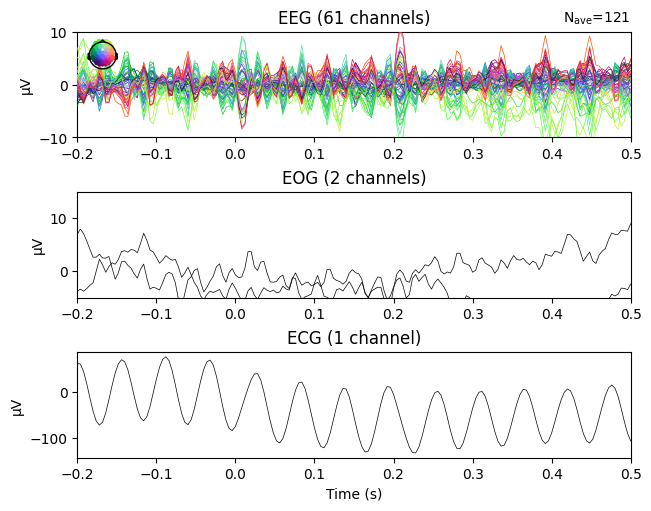

In [25]:
# we'll try to keep a consistent ylim across figures
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-10, 10), eog=(-5, 15)))

# plot the evoked for the EEG and the EOG sensors
fig = check_epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

##### o	Amplitude and Shape: 

The EOG channels (2 channels, likely vertical and horizontal EOG) show a gradual upward drift and fluctuations at ~0.25 seconds

##### o	Temporal Pattern:

- The peak at -0.1 seconds confirms the presence of eye blinks, as this is the typical latency for blink-related deflections in EOG channels.

- The large amplitude and sharp shape are characteristic of eye blinks, with the vertical EOG channel likely showing the larger deflection (if one channel is vertical EOG).

##### o	Artifact Magnitude: 

The amplitude (~10 µV) is significant, indicating prominent eye blinks in the check EEG data, consistent with the dataset’s description of blinks ~100 ms after "Sync On" events.


##### Rest Data

C:\Users\amany\AppData\Local\Temp\ipykernel_17460\1546109607.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = rest_epochs.average("all").plot(**plot_kwargs)


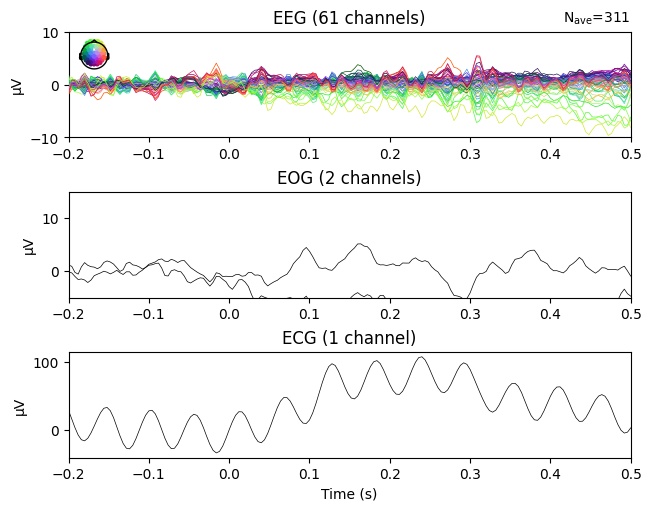

In [32]:
# plot the evoked for the EEG and the EOG sensors
fig = rest_epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

##### o	Amplitude and Shape: 

The EOG channels show a smaller peak at ~0.1 seconds with an amplitude of ~5 µV, followed by a negative deflection to ~-5 µV at ~0.3 seconds, and a slower return to baseline by 0.5 seconds.

##### o	Temporal Pattern:

- The peak at 0.1 seconds is present but less pronounced than in the check EEG data, indicating fewer or smaller eye blinks.

- The shape is similar (positive peak followed by a negative deflection), but the amplitude and sharpness are reduced.

##### o	Artifact Magnitude: 

The amplitude (~5 µV) is half that of the check EEG data, suggesting fewer eye blinks or less intense blinks during the resting state scan.


### Repair artifact using regression for Checker data

MNE Python tutorial suggests that artifacts that result in time waveforms on the sensors that are accurately reflected by some reference signal can be removed by regression. The Blink artifacts in our data are captured by bipolar EOG channels (vertical and horizontal) which provide a good example of this. Therefore, we will use the regression method to repair the ocular artifact.


#### Substract the evoked response from the epoch data

The MNE tutorial is covering the regression method using the (Gratton et al, 1983) method. (Gabriele Gratton, Michael G. H Coles, and Emanuel Donchin. A new method for off-line removal of ocular artifact. Electroencephalography and Clinical Neurophysiology, 55(4):468–484, 1983. doi:10.1016/0013-4694(83)90135-9)

Gratton et al. (1983) proposed calculating regression coefficients using EEG data after removing the evoked response, aiming to isolate noise—particularly EOG artifacts—which are not time-locked to stimuli, allowing for more accurate artifact estimation.

No projector specified for this dataset. Please consider the method self.add_proj.
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, EOGL, EOGU
[done]
No projector specified for this dataset. Please consider the method self.add_proj.


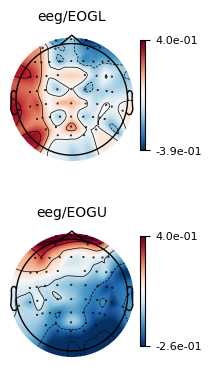

No projector specified for this dataset. Please consider the method self.add_proj.
Applying baseline correction (mode: mean)


C:\Users\amany\AppData\Local\Temp\ipykernel_17460\2102498504.py:15: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = c_epochs_clean_sub.average("all").plot(**plot_kwargs)


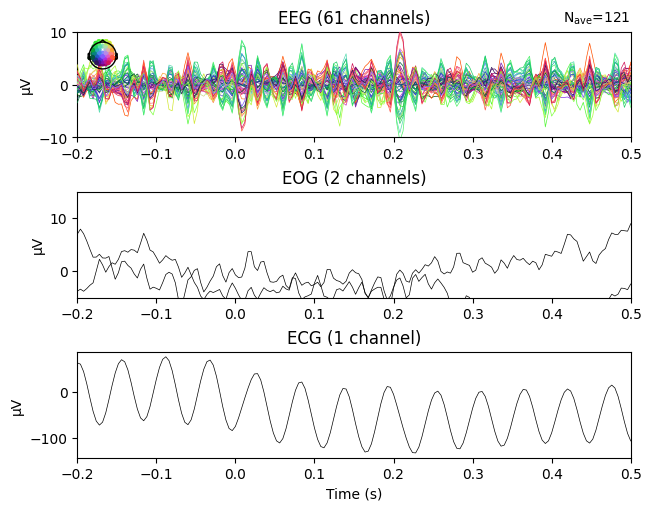

In [33]:
# Perform regression using the EOG sensor
c_model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(check_epochs)


# create epochs with the evoked subtracted out
c_epochs_sub = check_epochs.copy().subtract_evoked()

# perform regression
c_model_sub = EOGRegression(picks="eeg", picks_artifact="eog").fit(c_epochs_sub)
fig = c_model_sub.plot(vlim=(None, 0.4))
fig.set_size_inches(3, 2)

# apply the regression coefficients to the original epochs
c_epochs_clean_sub = c_model_plain.apply(check_epochs).apply_baseline()
fig = c_epochs_clean_sub.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

There is a minimal or no apparent change in the epochs' visual after the regression. Let's compare the original and cleaned evoked responses using the line plot

**Possible reasons for ineffective regression**

Regression assumes a linear relationship between the EOG signal and the ocular artifact in the EEG channels. However, eye blinks often have non-linear propagation to EEG channels (e.g., due to volume conduction, electrode placement), which regression may not fully capture.


combining channels using "mean"
combining channels using "mean"


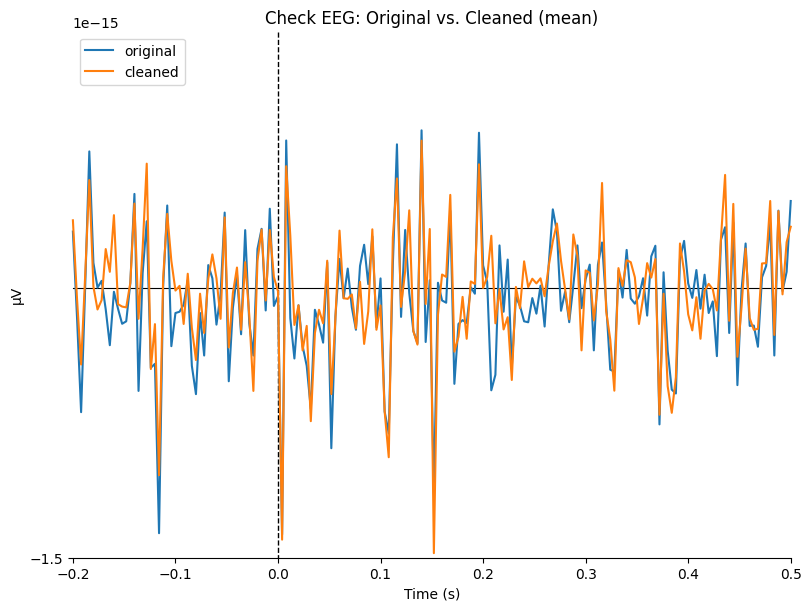

[<Figure size 800x600 with 1 Axes>]

In [34]:
# Plot original and cleaned evoked responses for comparison
evoked_original = check_epochs.average('all')
evoked_clean = c_epochs_clean_sub.average('all')
mne.viz.plot_compare_evokeds(
    dict(original=evoked_original, cleaned=evoked_clean),
    picks='eeg',
    combine='mean',
    title='Check EEG: Original vs. Cleaned'
)

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


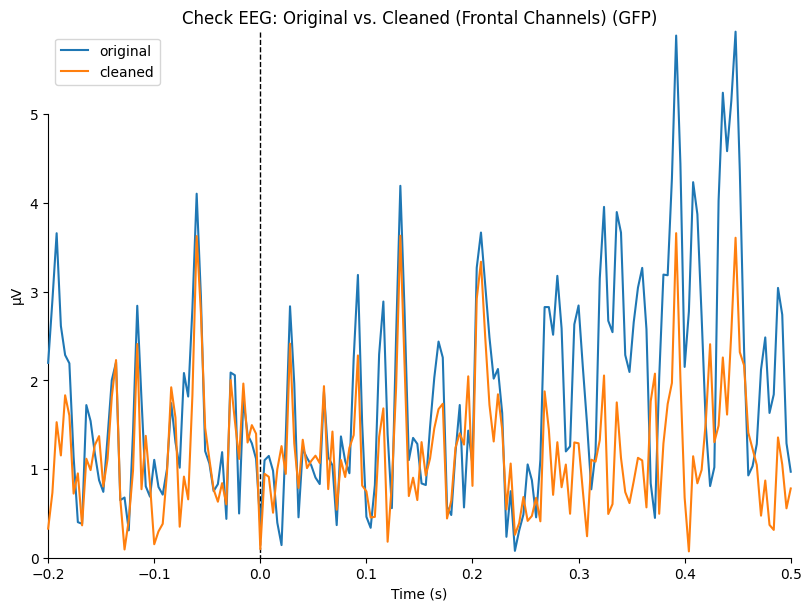

[<Figure size 800x600 with 1 Axes>]

In [35]:
# Plot frontal channels to focus on ocular artifact
mne.viz.plot_compare_evokeds(
    dict(original=evoked_original, cleaned=evoked_clean),
    picks=['Fz', 'Fp1', 'Fp2'],  # Frontal channels
    title='Check EEG: Original vs. Cleaned (Frontal Channels)'
)

The signal attenuation is more prominent with a focus on frontal channels

### Repair artifact with ICA component

Regression often struggles with ocular artifacts due to non-linear propagation and variability across channels. Independent Component Analysis (ICA) is a more robust method for removing ocular artifacts, as it decomposes the EEG signal into independent components and identifies those related to eye blinks.


#### ICA Diagnostics

##### 1- ICA scores

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 3.8s.
Using EOG channels: EOGL, EOGU
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)



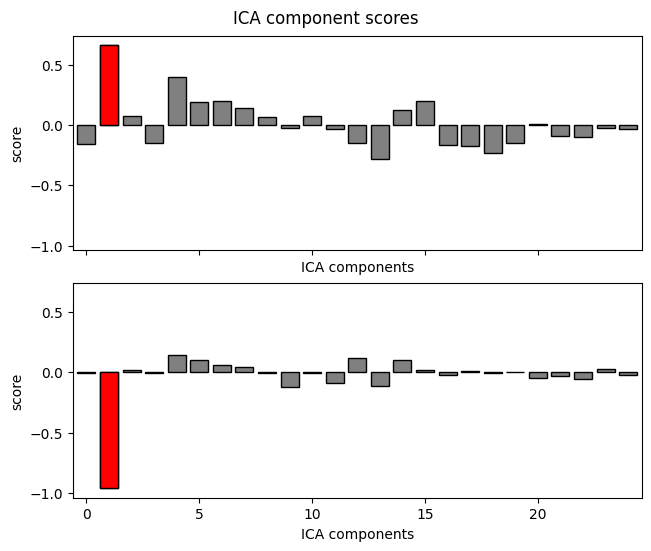

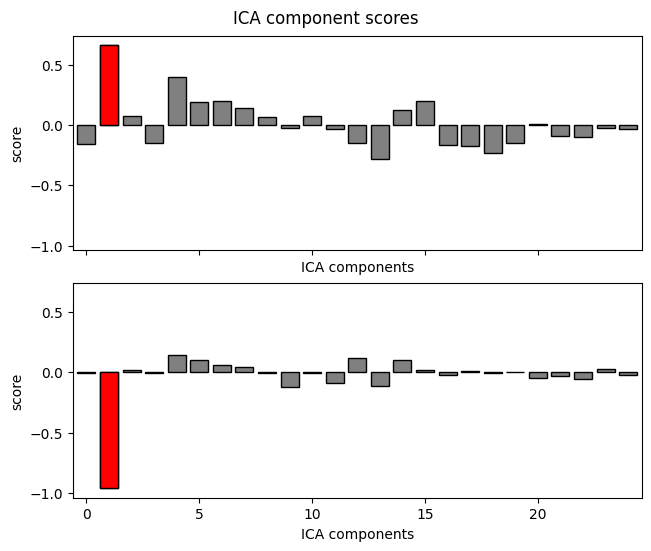

In [37]:
#fit ica 
ica = ICA(n_components=25, random_state=97)
ica.fit(check_eeg_data)

ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(check_eeg_data)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

The red Bar at Component 1: The component with the highest score (~0.5) is ICA001 (1-indexed). This indicates a strong correlation with the vertical EOG channel, suggesting that ICA001 is likely capturing the eye blink artifact.



    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated


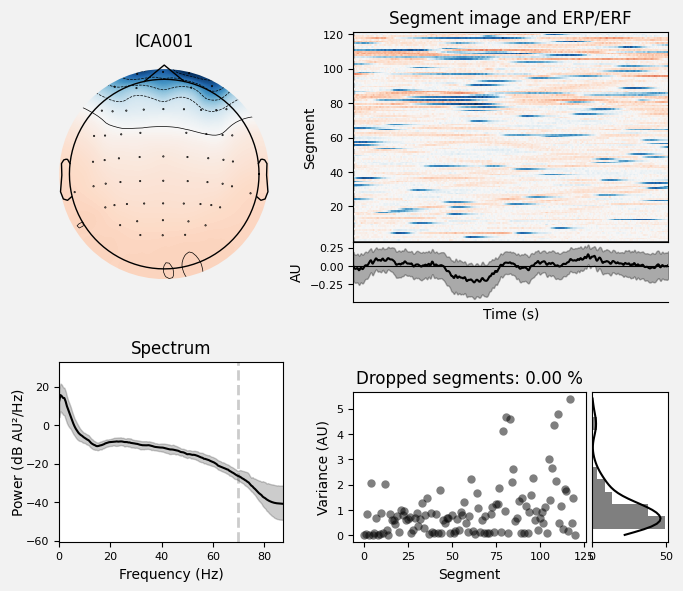

[<Figure size 700x600 with 6 Axes>]

In [38]:
# plot diagnostics
ica.plot_properties(check_eeg_data, picks=eog_indices)

**1. Topography**

The topomap shows strong activation over frontal electrodes, especially around the midline frontal region.

This spatial distribution is highly consistent with eye-blink artifacts (which affect frontal sensors the most).

Color gradient from blue (top) to red (bottom) reinforces this frontal dominance.

**2. ERP/Segment Image**

The image plot (segments over time) shows repeated brief events where the component sharply deviates (blue/red bands).

The ERP/ERF trace (averaged below the image) shows a clear transient deviation around ~0 seconds, then a return to baseline — another hallmark of eye blinks or quick eye movements.

**3. Spectrum**

The spectrum is broadband with more energy in the low-frequency range (<15 Hz), which is typical of ocular artifacts.

Power decays quickly after ~15 Hz, indicating non-neural, slower activity.

**4. Dropped Segments**

0.00% dropped segments → This component is consistently well-isolated, and there were no problematic epochs associated with it.

Scatter plot and histogram show some variation in variance across segments, but it's within a manageable range — no severe outliers.



Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 107 significant peaks
Number of EOG events detected: 107
Not setting metadata
107 matching events found
No baseline correction applied
Using data from preloaded Raw for 107 events and 251 original time points ...
0 bad epochs dropped


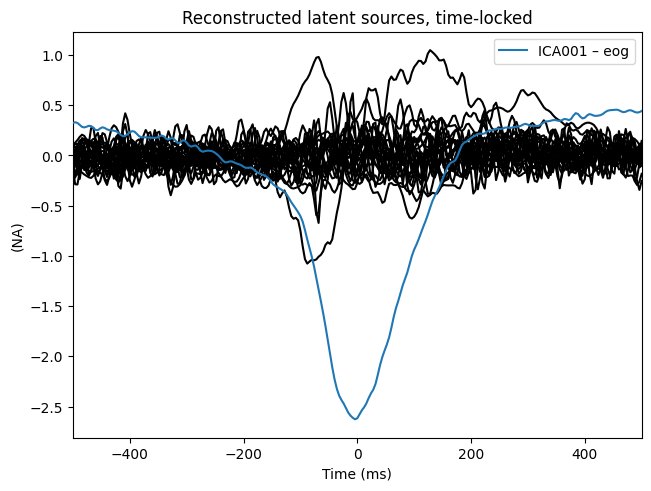

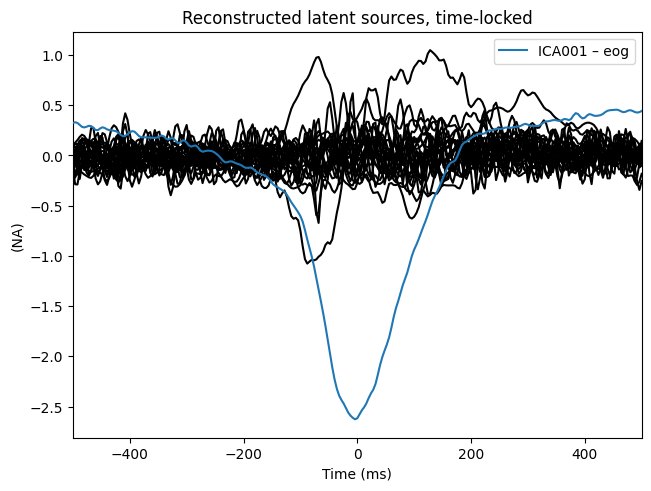

In [39]:
# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
eog_evoked = create_eog_epochs(check_eeg_data, ch_name=['Fp1','Fp2']).average()
ica.plot_sources(eog_evoked)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

Fitting ICA to data using 61 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 25 components
Fitting ICA took 12.3s.
Using EOG channels: EOGL, EOGU
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper t

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Ocular components identified: [np.int64(1)]
EOG scores: [array([-1.88557339e-01, -6.70414361e-01,  1.40365144e-01,  1.06034811e-01,
       -3.92993852e-01,  1.38063477e-01, -6.12956742e-02,  2.11659236e-01,
       -2.81305605e-02, -1.57668540e-01,  7.24366751e-02, -3.30251590e-02,
        6.66943140e-02, -2.63574897e-01,  1.08114551e-01, -2.37706574e-01,
        1.43200996e-01, -1.80266353e-02, -1.29368943e-01, -1.37077723e-01,
       -4.47777173e-04, -2.65039768e-03, -1.48352087e-01, -1.11137061e-01,
       -7.73816138e-02]), array([-0.03767373,  0.96229861,  0.03735478,  0.08128895, -0.13459023,
        0.06912822, -0.03133447,  0.11998942, -0.08341107,  0.05700896,
        0.01830708,  0.11405549,  0.01881417, -0.12273745,  0.07228901,
       -0.05925374,  0.04516285, -0.06756125, -0.02255867, -0.05879843,
        0.04241626,  0.02239922, -0.06841082,  0.01644376, -0.02586415])]
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA componen

C:\Users\amany\AppData\Local\Temp\ipykernel_17460\2357151209.py:37: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = c_epochs_clean_sub.average('all').plot( **plot_kwargs)


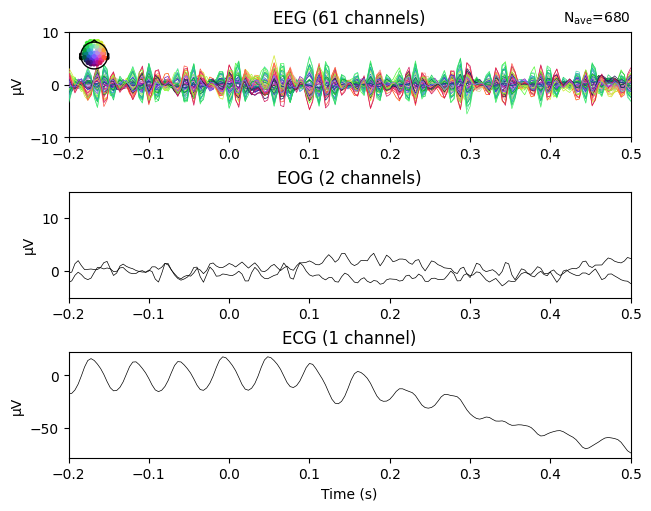

combining channels using "mean"
combining channels using "mean"


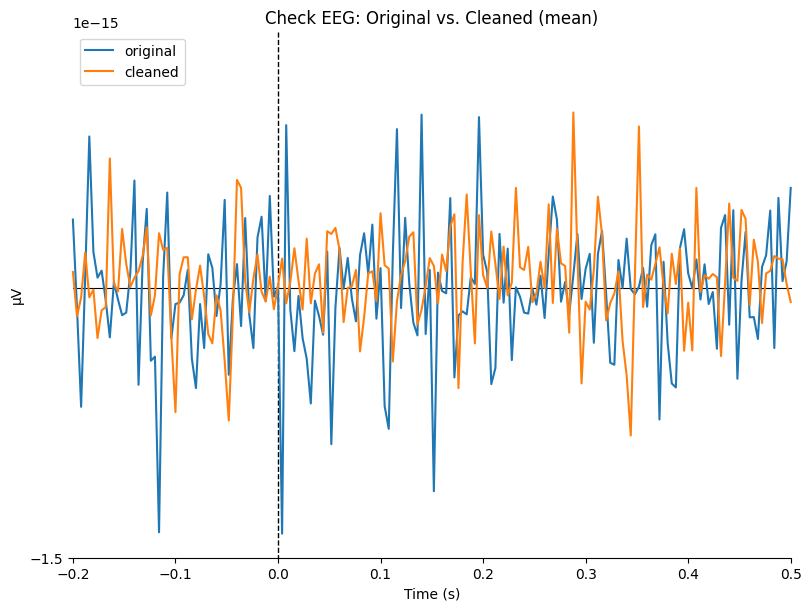

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


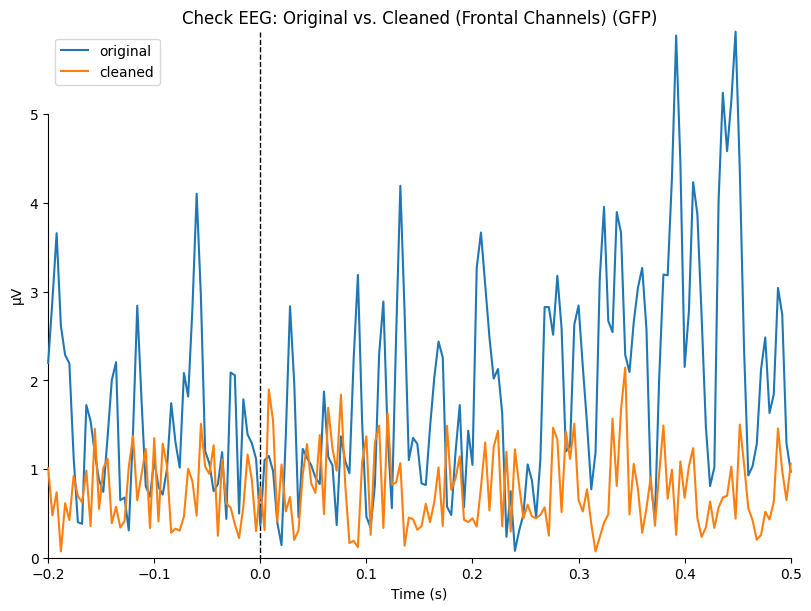

[<Figure size 800x600 with 1 Axes>]

In [42]:
# Copy the raw data
check_eeg_ica = check_eeg_data.copy()

# Apply high-pass filter (1 Hz) for ICA
check_eeg_ica.filter(l_freq=1, h_freq=None, fir_design='firwin')

# Ensure EOG channels are labeled correctly
eog_channels = [ch for ch in check_eeg_ica.ch_names if 'EOG' in ch]
check_eeg_ica.set_channel_types({ch: 'eog' for ch in eog_channels})

# Fit ICA
ica = ICA(n_components=25, random_state=97, max_iter=800)
ica.fit(check_eeg_ica)

# Automatically detect ocular components
eog_indices, eog_scores = ica.find_bads_eog(check_eeg_ica, threshold='auto')
print("Ocular components identified:", eog_indices)
print("EOG scores:", eog_scores)
ica.exclude = eog_indices


# Apply ICA
check_eeg_clean = ica.apply(check_eeg_ica.copy())
print("ICA applied. Excluded components:", ica.exclude)

# Recreate epochs
c_epochs_clean_sub = mne.Epochs(
    check_eeg_clean,
    events,
    event_id=event_id,
    preload=True,
    event_repeated='drop'
)
print(f"Number of epochs after ICA: {len(c_epochs_clean_sub)}")

# Plot evoked response (butterfly plot)
fig = c_epochs_clean_sub.average('all').plot( **plot_kwargs)

# Compare with original (line plot)
evoked_original = check_epochs.average('all')
evoked_clean = c_epochs_clean_sub.average('all')
mne.viz.plot_compare_evokeds(
    dict(original=evoked_original, cleaned=evoked_clean),
    picks='eeg',
    combine='mean',
    title='Check EEG: Original vs. Cleaned'
)

# Plot frontal channels to focus on ocular artifact
mne.viz.plot_compare_evokeds(
    dict(original=evoked_original, cleaned=evoked_clean),
    picks=['Fz', 'Fp1', 'Fp2'],  # Frontal channels
    title='Check EEG: Original vs. Cleaned (Frontal Channels)'
)

The visualization show that ICA is succeessful in removing the occular artifact.